In [147]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = fm.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.datasets import make_regression

In [148]:
path = "./Dataset/"

# is zero
isZero = pd.read_csv(path+"da_data.csv")

# no zero 
noZero = pd.read_csv(path+"da_data_nozero.csv")

# new features 
nf_pepper = pd.read_csv(path+"건고추Model.csv")
nf_green_onion = pd.read_csv(path+"대파Model.csv")
nf_garlic = pd.read_csv(path+"마늘Model.csv")
nf_radish = pd.read_csv(path+"무Model.csv")
nf_cabbage = pd.read_csv(path+"배추Model.csv")

In [149]:
X_column_pepper = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '건고추거래량', '건고추생산량', '건고추저장이월량', '건고추수입량', '건고추수입금액',
       '건고추재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_pepper = '건고추가격'

X_column_green_onion = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '대파거래량', '대파생산량', '대파저장이월량', '대파수입량', '대파수입금액',
       '대파재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_green_onion = '대파가격'

X_column_garlic = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '마늘거래량', '마늘생산량', '마늘저장이월량', '마늘수입량', '마늘수입금액',
       '마늘재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_garlic = '마늘가격'

X_column_radish = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '무거래량', '무생산량', '무저장이월량', '무수입량', '무수입금액',
       '무재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_radish = '무가격'

X_column_cabbage = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '배추거래량', '배추생산량', '배추저장이월량', '배추수입량', '배추수입금액',
       '배추재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_cabbage = '배추가격'

In [150]:
def pre_processing(data) :
    scaler = MinMaxScaler()
    scale_cols = data.iloc[:,1:].columns
    
    data.sort_index(ascending=False).reset_index(drop=True)
    
    scaled = scaler.fit_transform(data[scale_cols])
    scaled = pd.DataFrame(scaled)
    scaled.columns = scale_cols
    
    return scaled


def get_data_split(data, X_column, y_column) :
    train_X, test_X, train_y, test_y = train_test_split(
    data[X_column], 
    data[y_column],
    test_size=0.2,
    shuffle=True,   # random split 
    random_state=42) # seed 고정, same sampling 
    
    return train_X, test_X, train_y, test_y


def gridsearchCV (model, parameters, X_train, y_train) :
    grid = GridSearchCV(model, param_grid = parameters, scoring='accuracy', cv=2) # cv is fold num
    grid.fit(X_train, y_train)
    
    print('GridSearchCV 최적 하이퍼 파라미터 :', grid.best_params_)
    print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid.best_score_))
    print('GridSearchCV 최적 하이퍼 파라미터로 학습된 Esimator 반환')
    
    return grid.best_estimator_


def feature_importance(model_xgb) : 
    fig, ax = plt.subplots(figsize=(10,12))
    plot_importance(model_xgb, ax=ax)


def graph(pred, test_label) :
    plt.figure(figsize=(16, 9))
    plt.plot(test_label, label = 'actual')
    plt.plot(pred, label = 'prediction')
    plt.legend()
    plt.show()


def build_model(train_dataset):
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse',
                optimizer=Adam(learning_rate=0.001), 
                metrics=['mae', 'mse', 'accuracy'])
    
    return model

In [152]:
input_data = pre_processing(nf_green_onion)

train_X, test_X, train_y, test_y = get_data_split(input_data, X_column_green_onion, y_column_green_onion)

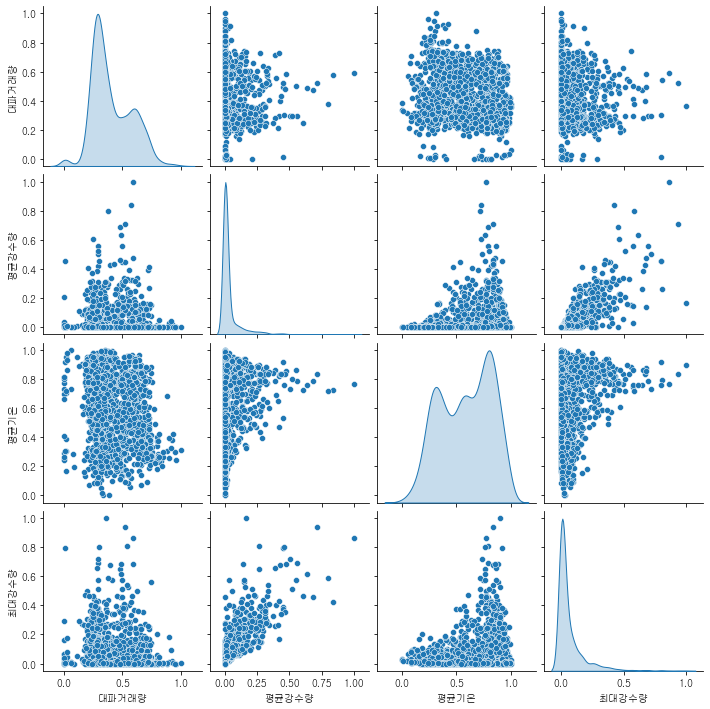

In [158]:
# 변수 작물 이름 바꿔주세요! 
sns.pairplot(train_X[["대파거래량", "평균강수량", "평균기온", "최대강수량"]], diag_kind="kde")

In [155]:
model_rnn = build_model(train_X)

model_rnn.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 64)                1728      
_________________________________________________________________
dense_27 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 65        
Total params: 5,953
Trainable params: 5,953
Non-trainable params: 0
_________________________________________________________________


In [156]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model_rnn.fit(
  train_X, train_y,
  epochs=EPOCHS, validation_split = 0.2, verbose=0, 
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [159]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,mae,mse,accuracy,val_loss,val_mae,val_mse,val_accuracy,epoch
0,0.015784,0.096597,0.015784,0.000720,0.012894,0.086913,0.012894,0.0,0
1,0.010389,0.078014,0.010389,0.000720,0.012076,0.079451,0.012076,0.0,1
2,0.009286,0.073352,0.009286,0.001441,0.009981,0.071403,0.009981,0.0,2
3,0.008576,0.070250,0.008576,0.001441,0.008990,0.067827,0.008990,0.0,3
4,0.007946,0.067421,0.007946,0.001441,0.009361,0.066360,0.009361,0.0,4
...,...,...,...,...,...,...,...,...,...
995,0.000743,0.020451,0.000743,0.001441,0.008526,0.061990,0.008526,0.0,995
996,0.000624,0.018398,0.000624,0.001441,0.008509,0.063772,0.008509,0.0,996
997,0.000624,0.018500,0.000624,0.001441,0.008168,0.060741,0.008168,0.0,997
998,0.000585,0.017811,0.000585,0.001441,0.008155,0.061792,0.008155,0.0,998


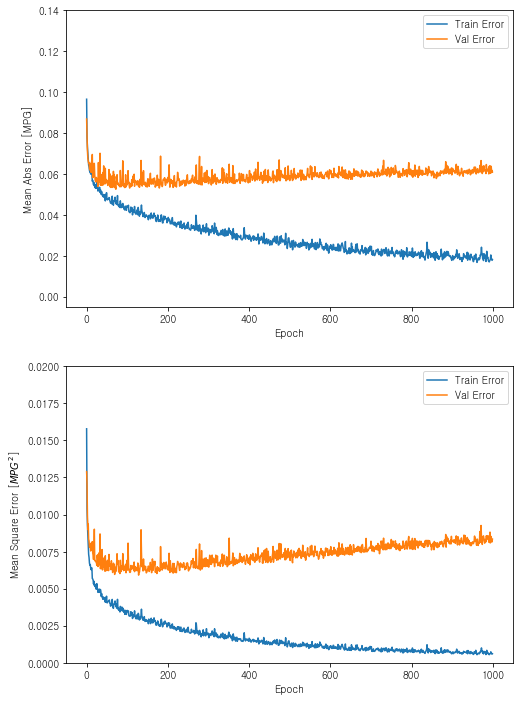

In [171]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure(figsize=(8,12))
    
    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.ylim([-0.005,0.14])
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    plt.ylim([0,0.02])
    plt.legend()
    plt.show()

plot_history(history)

In [165]:
# test set data를 통해 모델이 실전에 투입되었을 때 모델의 성능을 예측
loss, mae, mse = model_rnn.evaluate(test_X, test_y, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

14/14 - 0s - loss: 0.0066 - mae: 0.0591 - mse: 0.0066 - accuracy: 0.0000e+00


ValueError: too many values to unpack (expected 3)

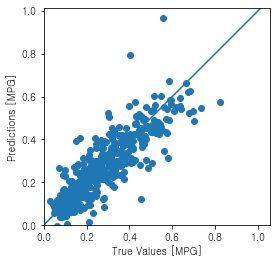

In [166]:
pred_rnn = model_rnn.predict(test_X).flatten()

plt.scatter(test_y, pred_rnn)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

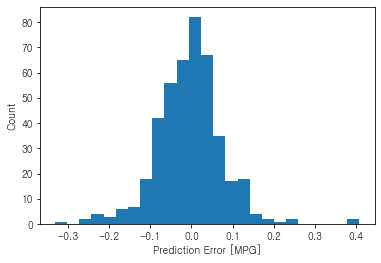

In [167]:
error = pred_rnn - test_y
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

In [168]:
df_result = pd.DataFrame(list(zip(test_y, pred_rnn)), columns=['true_y', 'rnn_pred_y'])
df_result 

,true_y,rnn_pred_y
0,0.251617,0.273616
1,0.210907,0.138654
2,0.505734,0.466981
3,0.372358,0.382926
4,0.664959,0.661192
...,...,...
429,0.187093,0.169213
430,0.226773,0.269784
431,0.130565,0.137663
432,0.383873,0.318891


In [169]:
# rmse
mse = mean_squared_error(test_y, pred_rnn)
print("mse:  %f" % mse)

rmse = np.sqrt(mse)
print("rmse: %f" %rmse)

mse:  0.006571
rmse: 0.081063


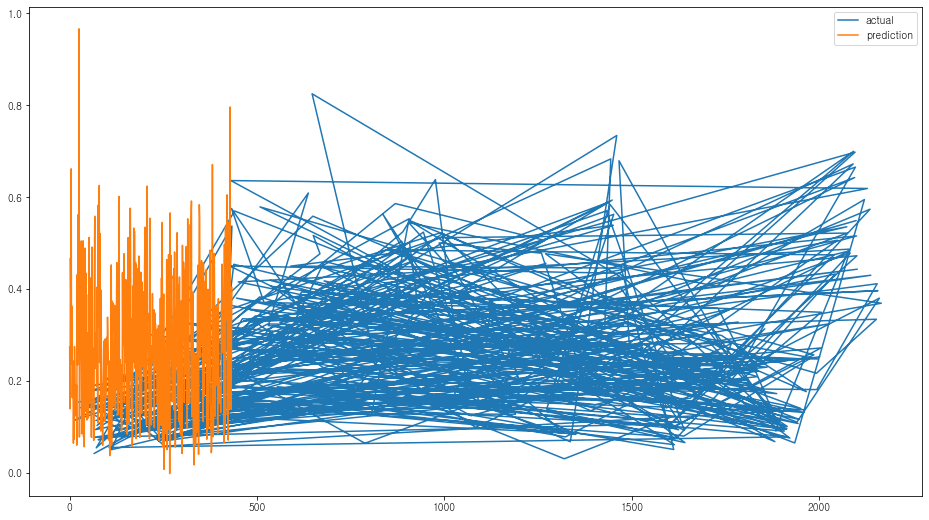

In [170]:
graph(pred_rnn, test_y)